In [ ]:
pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sayedhossainjobayer/skin-diseases-identification")

print("Path to dataset files:", path)

100%|██████████| 2.79G/2.79G [00:38<00:00, 77.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sayedhossainjobayer/skin-diseases-identification/versions/1


In [ ]:
import os

# Use the path returned by kagglehub
data_dir = path + '/Skin Disease Classification'

# List the main folders (Training/Testing)
print("Main directories:", os.listdir(data_dir))

Main directories: ['Psoriasis', 'Melanoma', 'Normal', 'Arsenic', 'Eczema']


In [9]:
import os
import shutil
import random

# 1. Define paths
# 'path' comes from your kagglehub download cell
base_source_dir = os.path.join(path, 'Skin Disease Classification')
split_base_dir = 'skin_data_split'

# List classes (Arsenic, Eczema, Normal, Psoriasis, etc.)
classes = [d for d in os.listdir(base_source_dir) if os.path.isdir(os.path.join(base_source_dir, d))]

# 2. Create the folder structure
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# 3. Shuffle and Move
for cls in classes:
    src_folder = os.path.join(base_source_dir, cls) # This is what src_path should have been
    images = os.listdir(src_folder)

    random.seed(42) # Keeps the "randomness" the same every time you run it
    random.shuffle(images)

    # Calculate split points (70% train, 15% val, 15% test)
    train_end = int(len(images) * 0.7)
    val_end = int(len(images) * 0.85)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Function to copy the files to their new home
    def copy_to_split(file_list, split_name):
        for f in file_list:
            shutil.copy(os.path.join(src_folder, f),
                        os.path.join(split_base_dir, split_name, cls, f))

    copy_to_split(train_imgs, 'train')
    copy_to_split(val_imgs, 'val')
    copy_to_split(test_imgs, 'test')

print("Data splitting complete! Your organized data is in 'skin_data_split'.")

Data splitting complete! Your organized data is in 'skin_data_split'.


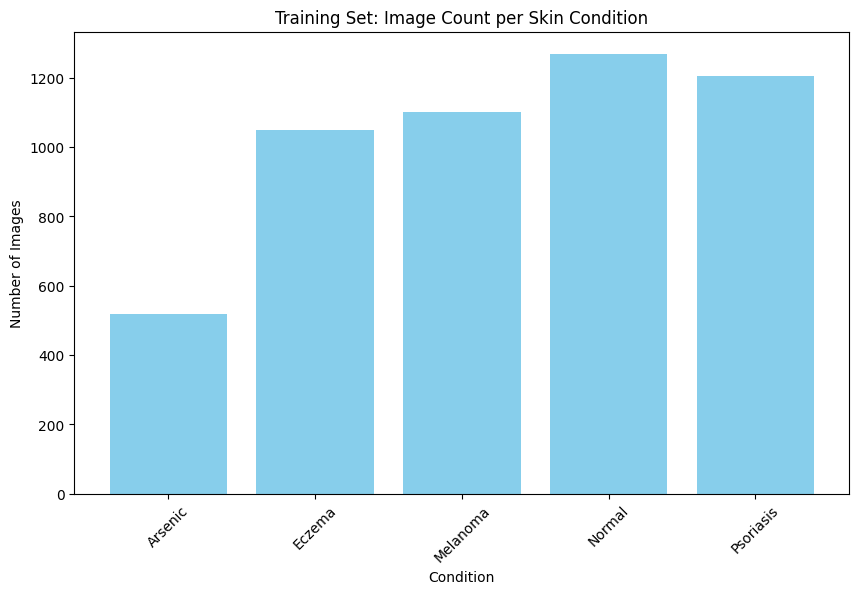

Training Class Distribution: {'Arsenic': 518, 'Eczema': 1050, 'Melanoma': 1103, 'Normal': 1270, 'Psoriasis': 1206}


In [10]:
import os
import matplotlib.pyplot as plt

# Define our split paths
split_base_dir = 'skin_data_split'
train_dir = os.path.join(split_base_dir, 'train')
classes = sorted(os.listdir(train_dir))

# Count images per class in the training set
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Training Set: Image Count per Skin Condition')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print("Training Class Distribution:", train_counts)

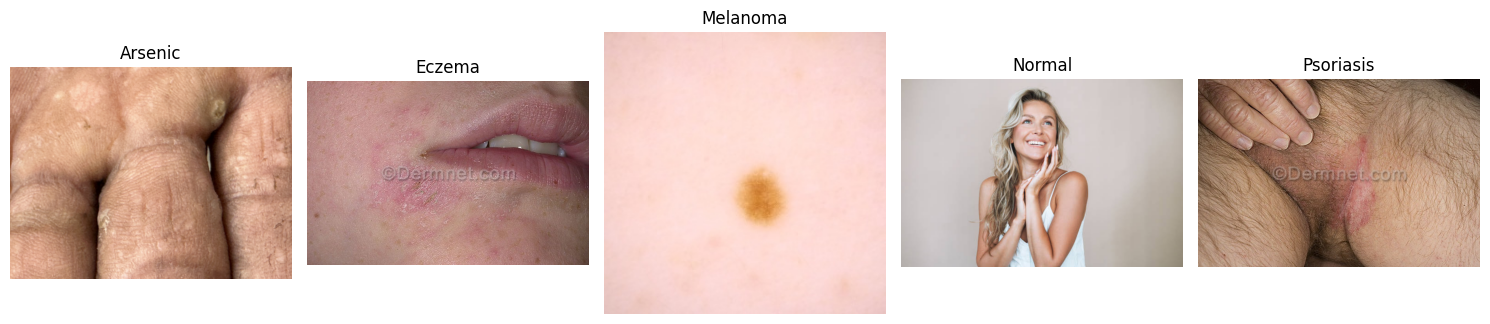

In [11]:
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    random_img = random.choice(os.listdir(cls_path))
    img = mpimg.imread(os.path.join(cls_path, random_img))

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 1. Training Transforms: Heavy Augmentation to handle imbalance
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Standard size for many pre-trained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight color variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Validation/Test Transforms: No Augmentation, just resizing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Create Datasets
train_data = datasets.ImageFolder('skin_data_split/train', transform=train_transform)
val_data = datasets.ImageFolder('skin_data_split/val', transform=test_transform)
test_data = datasets.ImageFolder('skin_data_split/test', transform=test_transform)

# 4. Create Loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Ready! Training batches: {len(train_loader)}")

Ready! Training batches: 161


In [21]:
import torch.nn as nn
from torchvision import models

# 1. Load the pre-trained ResNet18 model
# 'weights' ensures we get the knowledge from ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2. Modify the final fully connected layer (fc)
# We find how many inputs the original head had
num_ftrs = model.fc.in_features

# We replace the original 1,000-class head with a new 5-class head
model.fc = nn.Linear(num_ftrs, 5)

# 3. Move the model to your GPU (T4 in Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model successfully loaded on {device}")

Model successfully loaded on cuda


In [22]:
import torch.optim as optim

# Standard choice for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with a small learning rate for fine-tuning
# We use a small LR (1e-4) so we don't 'break' the pre-trained weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
import numpy as np

num_epochs = 15 # Skin textures are subtle; let's give it 15 epochs
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # Multi-class CrossEntropy
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1) # Get the index of the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_data)
    train_acc = correct / total

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_data)
    val_acc = val_correct / val_total

    # Save history for your project report plots
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} -> "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/15 -> Train Loss: 0.4188, Acc: 0.8135 | Val Loss: 0.2613, Acc: 0.8849
Epoch 2/15 -> Train Loss: 0.2577, Acc: 0.8844 | Val Loss: 0.2906, Acc: 0.8685
Epoch 3/15 -> Train Loss: 0.2110, Acc: 0.9079 | Val Loss: 0.2654, Acc: 0.8776
Epoch 4/15 -> Train Loss: 0.1795, Acc: 0.9236 | Val Loss: 0.2192, Acc: 0.9166
Epoch 5/15 -> Train Loss: 0.1685, Acc: 0.9297 | Val Loss: 0.2822, Acc: 0.8976
Epoch 6/15 -> Train Loss: 0.1394, Acc: 0.9448 | Val Loss: 0.2418, Acc: 0.9112
Epoch 7/15 -> Train Loss: 0.1261, Acc: 0.9499 | Val Loss: 0.2170, Acc: 0.9175
Epoch 8/15 -> Train Loss: 0.1128, Acc: 0.9553 | Val Loss: 0.2411, Acc: 0.9257
Epoch 9/15 -> Train Loss: 0.1154, Acc: 0.9555 | Val Loss: 0.2414, Acc: 0.9148
Epoch 10/15 -> Train Loss: 0.0854, Acc: 0.9693 | Val Loss: 0.2365, Acc: 0.9157
Epoch 11/15 -> Train Loss: 0.0879, Acc: 0.9656 | Val Loss: 0.2354, Acc: 0.9148


KeyboardInterrupt: 

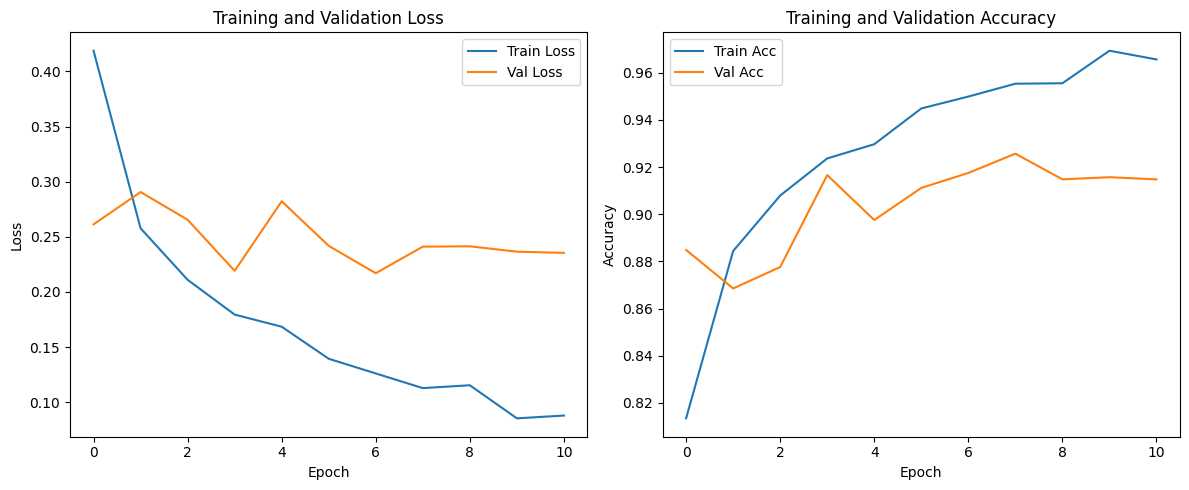

In [24]:
import matplotlib.pyplot as plt

# 1. Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Final Accuracy on unseen Test Set: {(100 * test_correct / test_total):.2f}%")

Final Accuracy on unseen Test Set: 91.87%


In [26]:
import torch

# Save just the weights (Recommended for inference)
torch.save(model.state_dict(), 'skin_guardian_weights.pth')
print("Standard weights saved!")

Standard weights saved!


In [29]:
# Install the required ONNX dependencies
!pip install --upgrade onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 15.6 MB/s eta 0:00:00


In [30]:
# saving with onnx
# 1. Set model to evaluation mode (Turns off training-only layers)
model.eval()

# 2. Create a 'dummy' image of the correct size (Batch size 1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 3. Export the model
torch.onnx.export(
    model,
    dummy_input,
    "skin_guardian.onnx",
    export_params=True,      # Store the weights inside the model file
    opset_version=12,        # Standard version for compatibility
    do_constant_folding=True, # Optimization trick
    input_names=['input'],   # Name the input for the API
    output_names=['output']  # Name the output for the API
)

print("ONNX model exported successfully!")

W0119 22:48:29.532000 263 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
ONNX model exported successfully!
